# Large scale learning with kernels

1. [Imports](#imports)
2. [Random Fourier Features](#nys)
3. [Nÿstrom](#nÿstrom)
3. [Experiments on synthetic data](#synthetic)
    1. [Performance with D](#synt_D)
    2. [Influence of the regularization](#synt_reg)
4. [Experiments on the CT Slices dataset](#CT)
    1. [Performance with D](#CT_D)
    2. [Influence of the regularization](#CT_reg)
5. [Experiments on the MillionSongs dataset](#MillionSongs)
    1. [Performance with D](#MillionSongs_D)
    2. [Influence of the regularization](#MillionSongs_reg)

## Imports <a name="imports"></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR, SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from time import time
import matplotlib.pyplot as plt
import copy

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import os

DATA = {
    "YearPredictionMSD.txt.zip": "1R3CXYssjftxi7HIXXgeWCAZh65ByEumt",
    "slice_localization_data.zip": "1ZJamggugQuj-sE1EFWfghhR3dEY2K9Ib",
}

for file_name, file_id in DATA.items():
    output_file = os.path.join('data', file_name)
    if not os.path.isfile(output_file):
        gdd.download_file_from_google_drive(file_id=file_id, dest_path=output_file)

## Nyström <a name="nÿstrom"></a>

In [3]:
from rkhs.nystrom import PlainNystromRegressor, SGDPlainNystromRegressor, SGDPlainNystromClassifier

## Experiments on synthetic data: classification <a name="synthetic"></a>

In [4]:
X, y = make_classification(n_samples=50000, n_features=120, n_informative=15, n_classes=2, random_state=17)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [6]:
lin = Pipeline([('Scaler',StandardScaler()),
                ('LinearSVC', LinearSVC(dual=False)),])

t0 = time()
lin.fit(X_train, y_train)
time_lin = time() - t0

y_pred_train_lin = lin.predict(X_train)                      
score_train_lin = accuracy_score(y_train, y_pred_train_lin)

y_pred_lin = lin.predict(X_test)                      
score_lin = accuracy_score(y_test, y_pred_lin)

In [7]:
gauss = Pipeline([('Scaler',StandardScaler()),
                  ('SVC', SVC(kernel='rbf')),])

t0 = time()
gauss.fit(X_train, y_train)
time_gauss = time() - t0

y_pred_train_gauss = gauss.predict(X_train)                      
score_train_gauss = accuracy_score(y_train, y_pred_train_gauss)

y_pred_gauss = gauss.predict(X_test)                      
score_gauss = accuracy_score(y_test, y_pred_gauss)

In [8]:
np.savetxt('synthetic_clf_results/score_lin.csv', np.asarray([score_lin]), delimiter=',')
np.savetxt('synthetic_clf_results/score_train_lin.csv', np.asarray([score_train_lin]), delimiter=',')
np.savetxt('synthetic_clf_results/time_lin.csv', np.asarray([time_lin]), delimiter=',')
np.savetxt('synthetic_clf_results/score_gauss.csv', np.asarray([score_gauss]), delimiter=',')
np.savetxt('synthetic_clf_results/score_train_gauss.csv', np.asarray([score_train_gauss]), delimiter=',')
np.savetxt('synthetic_clf_results/time_gauss.csv', np.asarray([time_gauss]), delimiter=',')

### Performance with D <a name="synt_D"></a>

In [9]:
from tqdm import tqdm
nD = 10
list_D = np.linspace(300,3500,nD,dtype=int)
M = 10
scores_nys = np.empty((nD,M))
scores_train_nys = np.empty((nD,M))
times_nys = np.empty((nD,M))

for i,D in enumerate(tqdm(list_D)):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('Nystrom', SGDPlainNystromClassifier(m=D)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys[i,j] = accuracy_score(y_test, y_pred_nys)

100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [14:13<00:00, 85.33s/it]


In [10]:
np.savetxt('synthetic_clf_results/scores_nys.csv', scores_nys, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys.csv', scores_train_nys, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys.csv', times_nys, delimiter=',')
np.savetxt('synthetic_clf_results/list_D_nys.csv', list_D, delimiter=',')

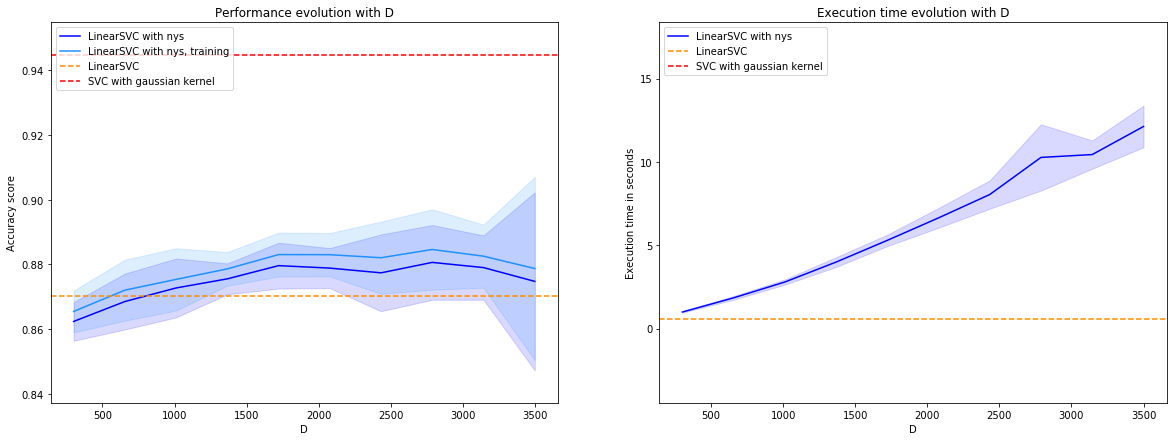

In [11]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1)),
            max(np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)+0.01
y_min = min(min(np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1)),
            min(np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)-0.01

ax1.set_ylim(y_min, y_max)

ax1.plot(list_D, np.mean(scores_nys, axis=1), '-', color='blue', label='LinearSVC with nys')
ax1.fill_between(list_D, np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1),
                 np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1), 
                 color='blue', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_nys, axis=1), '-', color='dodgerblue', label='LinearSVC with nys, training')
ax1.fill_between(list_D, np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1),
                 np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1), 
                 color='dodgerblue', alpha=0.15)

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax1.set_title("Performance evolution with D")
ax1.set_xlabel("D")
ax1.set_ylabel("Accuracy score")

ax1.legend(loc='upper left') #, handles=handles, labels=labels

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_nys, axis=1) + np.std(times_nys, axis=1)),time_lin)+5
y_min = min(min(np.mean(times_nys, axis=1) - np.std(times_nys, axis=1)),time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_D, np.mean(times_nys, axis=1), '-', color='blue', label='LinearSVC with nys')
ax2.fill_between(list_D, np.mean(times_nys, axis=1) - np.std(times_nys, axis=1),
                 np.mean(times_nys, axis=1) + np.std(times_nys, axis=1), 
                 color='blue', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax2.set_title("Execution time evolution with D")
ax2.set_xlabel("D")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("nys_D_influence_synthetic_clf_nys")
plt.show()

In [12]:
print("SVC with gaussian kernel execution time:", time_gauss)

SVC with gaussian kernel execution time: 256.17949652671814


### Influence of the regularization  <a name="synt_reg"></a>

In [13]:
nC = 8
list_C = np.linspace(0.01,2,nC)
M = 10

In [14]:
scores_nys_h = np.empty((nC,M))
scores_train_nys_h = np.empty((nC,M))
times_nys_h = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromClassifier(m=2500, lambda_reg=C, loss='hinge')),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_h[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_h[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_h[i,j] = accuracy_score(y_test, y_pred_nys)

In [15]:
scores_nys_sh = np.empty((nC,M))
scores_train_nys_sh = np.empty((nC,M))
times_nys_sh = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromClassifier(m=2500, lambda_reg=C, , loss='squared_hinge')),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_sh[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_sh[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_sh[i,j] = accuracy_score(y_test, y_pred_nys)

SyntaxError: invalid syntax (<ipython-input-15-71abe0f3b2c7>, line 8)

In [ ]:
np.savetxt('synthetic_clf_results/scores_nys_h.csv', scores_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_h.csv', scores_train_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_h.csv', times_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_nys_sh.csv', scores_nys_l2, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_sh.csv', scores_train_nys_l2, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_sh.csv', times_nys_l2, delimiter=',')
np.savetxt('synthetic_clf_results/list_C_nys.csv', list_C, delimiter=',')

In [ ]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_nys_h, axis=1) + np.std(scores_nys_h, axis=1)),
            max(np.mean(scores_train_nys_h, axis=1) + np.std(scores_train_nys_h, axis=1)),
            max(np.mean(scores_nys_sh, axis=1) + np.std(scores_nys_sh, axis=1)),
            max(np.mean(scores_train_nys_sh, axis=1) + np.std(scores_train_nys_sh, axis=1)),
            score_lin, score_gauss)+0.01
y_min = min(min(np.mean(scores_nys_h, axis=1) - np.std(scores_nys_h, axis=1)),
            min(np.mean(scores_train_nys_h, axis=1) - np.std(scores_train_nys_h, axis=1)),
            min(np.mean(scores_nys_sh, axis=1) - np.std(scores_nys_sh, axis=1)),
            min(np.mean(scores_train_nys_sh, axis=1) - np.std(scores_train_nys_sh, axis=1)),
            score_lin, score_gauss)-0.01

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C, np.mean(scores_nys_h, axis=1), '-', color='blue', label='LinearSVC with nys, hinge loss')
ax1.fill_between(list_C, np.mean(scores_nys_h, axis=1) - np.std(scores_nys_h, axis=1),
                 np.mean(scores_nys_h, axis=1) + np.std(scores_nys_h, axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_h, axis=1), '-', color='dodgerblue', label='LinearSVC with nys, hinge loss, training')
ax1.fill_between(list_C, np.mean(scores_train_nys_h, axis=1) - np.std(scores_train_nys_h, axis=1),
                 np.mean(scores_train_nys_h, axis=1) + np.std(scores_train_nys_h, axis=1), 
                 color='dodgerblue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_nys_sh, axis=1), '-', color='darkgreen', label='LinearSVC with nys, squared-hinge loss')
ax1.fill_between(list_C, np.mean(scores_nys_sh, axis=1) - np.std(scores_nys_sh, axis=1),
                 np.mean(scores_nys_sh, axis=1) + np.std(scores_nys_sh, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_sh, axis=1), '-', color='lightgreen', label='LinearSVC with nys, squared-hinge loss, training')
ax1.fill_between(list_C, np.mean(scores_train_nys_sh, axis=1) - np.std(scores_train_nys_sh, axis=1),
                 np.mean(scores_train_nys_sh, axis=1) + np.std(scores_train_nys_sh, axis=1), 
                 color='lightgreen', alpha=0.15)

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy score")

ax1.legend(loc='lower left') #, handles=handles, labels=labels

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_nys_h, axis=1) + np.std(times_nys_h, axis=1)),
            max(np.mean(times_nys_sh, axis=1) + np.std(times_nys_sh, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_nys_h, axis=1) - np.std(times_nys_h, axis=1)),
            min(np.mean(times_nys_sh, axis=1) - np.std(times_nys_sh, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C, np.mean(times_nys_h, axis=1), '-', color='blue', label='LinearSVC with nys, hinge loss')
ax2.fill_between(list_C, np.mean(times_nys_h, axis=1) - np.std(times_nys_h, axis=1),
                 np.mean(times_nys_h, axis=1) + np.std(times_nys_h, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_nys_sh, axis=1), '-', color='green', label='LinearSVC with nys, squared-hinge loss')
ax2.fill_between(list_C, np.mean(times_nys_sh, axis=1) - np.std(times_nys_sh, axis=1),
                 np.mean(times_nys_sh, axis=1) + np.std(times_nys_sh, axis=1), 
                 color='green', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_loss_influence_synthetic_clf_nys.png")
plt.show()

In [ ]:
print("SVC with gaussian kernel execution time:", time_gauss)

In [ ]:
scores_nys_l1 = np.empty((nC,M))
scores_train_nys_l1 = np.empty((nC,M))
times_nys_l1 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromClassifier(m=2500, lambda_reg=C, loss='hinge', penalty='l1')),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_l1[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l1[i,j] = accuracy_score(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l1[i,j] = accuracy_score(y_test, y_pred_nys)

In [ ]:
scores_nys_l2 = scores_nys_sh
scores_train_nys_l2 = scores_train_nys_sh
times_nys_l2 = times_nys_sh

In [ ]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_nys_l1, axis=1) + np.std(scores_nys_l1, axis=1)),
            max(np.mean(scores_train_nys_l1, axis=1) + np.std(scores_train_nys_l1, axis=1)),
            max(np.mean(scores_nys_l2, axis=1) + np.std(scores_nys_l2, axis=1)),
            max(np.mean(scores_train_nys_l2, axis=1) + np.std(scores_train_nys_l2, axis=1)),
            score_lin, score_gauss)+0.01
y_min = min(min(np.mean(scores_nys_l1, axis=1) - np.std(scores_nys_l1, axis=1)),
            min(np.mean(scores_train_nys_l1, axis=1) - np.std(scores_train_nys_l1, axis=1)),
            min(np.mean(scores_nys_l2, axis=1) - np.std(scores_nys_l2, axis=1)),
            min(np.mean(scores_train_nys_l2, axis=1) - np.std(scores_train_nys_l2, axis=1)),
            score_lin, score_gauss)-0.01

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C, np.mean(scores_nys_l1, axis=1), '-', color='blue', label='LinearSVC with nys, regularization L1')
ax1.fill_between(list_C, np.mean(scores_nys_l1, axis=1) - np.std(scores_nys_l1, axis=1),
                 np.mean(scores_nys_l1, axis=1) + np.std(scores_nys_l1, axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVC with nys, regularization L1, training')
ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1) - np.std(scores_train_nys_l1, axis=1), ':',color='dodgerblue')
ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1) + np.std(scores_train_nys_l1, axis=1), ':',color='dodgerblue')

ax1.plot(list_C, np.mean(scores_nys_l2, axis=1), '-', color='darkgreen', label='LinearSVC with nys, regularization L2')
ax1.fill_between(list_C, np.mean(scores_nys_l2, axis=1) - np.std(scores_nys_l2, axis=1),
                 np.mean(scores_nys_l2, axis=1) + np.std(scores_nys_l2, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1), '*', markersize=8, color='lightgreen',
         label='LinearSVC with nys, regularization L2, training')
ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1) - np.std(scores_train_nys_l2, axis=1), ':',color='lightgreen')
ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1) + np.std(scores_train_nys_l2, axis=1), ':',color='lightgreen')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Accuracy score")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[1].set_linestyle(':')
handles[3].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_nys_l1, axis=1) + np.std(times_nys_l1, axis=1)),
            max(np.mean(times_nys_l2, axis=1) + np.std(times_nys_l2, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_nys_l1, axis=1) - np.std(times_nys_l1, axis=1)),
            min(np.mean(times_nys_l2, axis=1) - np.std(times_nys_l2, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C, np.mean(times_nys_l1, axis=1), '-', color='blue', label='LinearSVC with nys, regularization L1')
ax2.fill_between(list_C, np.mean(times_nys_l1, axis=1) - np.std(times_nys_l1, axis=1),
                 np.mean(times_nys_l1, axis=1) + np.std(times_nys_l1, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_nys_l2, axis=1), '-', color='green', label='LinearSVC with nys, regularization L2')
ax2.fill_between(list_C, np.mean(times_nys_l2, axis=1) - np.std(times_nys_l2, axis=1),
                 np.mean(times_nys_l2, axis=1) + np.std(times_nys_l2, axis=1), 
                 color='green', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVC')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVC with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_influence_synthetic_clf_nys.png")
plt.show()

In [ ]:
print("SVC with gaussian kernel execution time:", time_gauss)

In [ ]:
np.savetxt('synthetic_clf_results/scores_nys_l1.csv', scores_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_l1.csv', scores_train_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_l1.csv', times_nys_l1, delimiter=',')
np.savetxt('synthetic_clf_results/scores_nys_l2.csv', scores_nys_l2, delimiter=',')
np.savetxt('synthetic_clf_results/scores_train_nys_l2.csv', scores_train_nys_l2, delimiter=',')
np.savetxt('synthetic_clf_results/times_nys_l2.csv', times_nys_l2, delimiter=',')

## Experiments on the CT Slices dataset <a name="CT"></a>

In [ ]:
data = pd.read_csv('data/slice_localization_data.zip')

In [ ]:
data.shape

In [ ]:
features = data.drop('reference', axis=1)

In [ ]:
y = data.loc[:,'reference']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=24)
X_train = X_train.values
X_test = X_test.values

In [ ]:
lin = Pipeline([('Scaler',StandardScaler()),
                ('LinearSVR', LinearSVR(max_iter=10000)),])

t0 = time()
lin.fit(X_train, y_train)
time_lin = time() - t0

y_pred_train_lin = lin.predict(X_train)                      
score_train_lin = mean_squared_error(y_train, y_pred_train_lin)

y_pred_lin = lin.predict(X_test)                      
score_lin = mean_squared_error(y_test, y_pred_lin)

In [ ]:
gauss = Pipeline([('Scaler',StandardScaler()),
                  ('SVR', SVR(kernel='rbf')),])

t0 = time()
gauss.fit(X_train, y_train)
time_gauss = time() - t0

y_pred_train_gauss = gauss.predict(X_train)                      
score_train_gauss = mean_squared_error(y_train, y_pred_train_gauss)

y_pred_gauss = gauss.predict(X_test)                      
score_gauss = mean_squared_error(y_test, y_pred_gauss)

In [ ]:
np.savetxt('CT_results/score_lin.csv', np.asarray([score_lin]), delimiter=',')
np.savetxt('CT_results/score_train_lin.csv', np.asarray([score_train_lin]), delimiter=',')
np.savetxt('CT_results/time_lin.csv', np.asarray([time_lin]), delimiter=',')
np.savetxt('CT_results/score_gauss.csv', np.asarray([score_gauss]), delimiter=',')
np.savetxt('CT_results/score_train_gauss.csv', np.asarray([score_train_gauss]), delimiter=',')
np.savetxt('CT_results/time_gauss.csv', np.asarray([time_gauss]), delimiter=',')

### Performance with D <a name="CT_D"></a>

In [ ]:
nD = 10
list_D = np.linspace(300,3500,nD,dtype=int)
M = 10
scores_nys = np.empty((nD,M))
scores_train_nys = np.empty((nD,M))
times_nys = np.empty((nD,M))

for i,D in enumerate(list_D):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromRegressor(m=D)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys[i,j] = mean_squared_error(y_test, y_pred_nys)

In [ ]:
np.savetxt('CT_results/scores_nys.csv', scores_nys, delimiter=',')
np.savetxt('CT_results/scores_train_nys.csv', scores_train_nys, delimiter=',')
np.savetxt('CT_results/times_nys.csv', times_nys, delimiter=',')
np.savetxt('CT_results/list_D.csv', list_D, delimiter=',')

In [ ]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1)),
            max(np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)+1
y_min = min(min(np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1)),
            min(np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)-1

ax1.set_ylim(y_min, y_max)

ax1.plot(list_D, np.mean(scores_nys, axis=1), '-', color='blue', label='LinearSVR with nys')
ax1.fill_between(list_D, np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1),
                 np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1), 
                 color='blue', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_nys, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with nys, training')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1), ':',color='dodgerblue')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1), ':',color='dodgerblue')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with D")
ax1.set_xlabel("D")
ax1.set_ylabel("Mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[1].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_nys, axis=1) + np.std(times_nys, axis=1)),time_lin)+5
y_min = min(min(np.mean(times_nys, axis=1) - np.std(times_nys, axis=1)),time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_D, np.mean(times_nys, axis=1), '-', color='blue', label='LinearSVR with nys')
ax2.fill_between(list_D, np.mean(times_nys, axis=1) - np.std(times_nys, axis=1),
                 np.mean(times_nys, axis=1) + np.std(times_nys, axis=1), 
                 color='blue', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with D")
ax2.set_xlabel("D")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("D_influence_CT_nys")
plt.show()

In [ ]:
print("SVR with gaussian kernel execution time:", time_gauss)

### Influence of the regularization  <a name="CT_reg"></a>

In [ ]:
nC = 8
list_C = np.linspace(0.01,2,nC)
M = 10

In [ ]:
scores_nys_l1 = np.empty((nC,M))
scores_train_nys_l1 = np.empty((nC,M))
times_nys_l1 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromRegressor(m=2000, lambda_reg=C)),])
        
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_l1[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l1[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l1[i,j] = mean_squared_error(y_test, y_pred_nys)

In [ ]:
scores_nys_l2 = np.empty((nC,M))
scores_train_nys_l2 = np.empty((nC,M))
times_nys_l2 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromRegressor(m=2000, lambda_reg=C, 
                                                         loss='squared_epsilon_insensitive')),])
                
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_l2[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l2[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l2[i,j] = mean_squared_error(y_test, y_pred_nys)

In [ ]:
np.savetxt('CT_results/scores_nys_l1.csv', scores_nys_l1, delimiter=',')
np.savetxt('CT_results/scores_train_nys_l1.csv', scores_train_nys_l1, delimiter=',')
np.savetxt('CT_results/times_nys_l1.csv', times_nys_l1, delimiter=',')
np.savetxt('CT_results/scores_nys_l2.csv', scores_nys_l2, delimiter=',')
np.savetxt('CT_results/scores_train_nys_l2.csv', scores_train_nys_l2, delimiter=',')
np.savetxt('CT_results/times_nys_l2.csv', times_nys_l2, delimiter=',')
np.savetxt('CT_results/list_C_nys.csv', list_C, delimiter=',')

In [ ]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_nys_l1, axis=1) + np.std(scores_nys_l1, axis=1)),
            max(np.mean(scores_train_nys_l1, axis=1) + np.std(scores_train_nys_l1, axis=1)),
            max(np.mean(scores_nys_l2, axis=1) + np.std(scores_nys_l2, axis=1)),
            max(np.mean(scores_train_nys_l2, axis=1) + np.std(scores_train_nys_l2, axis=1)),
            score_lin, score_gauss)+1
y_min = min(min(np.mean(scores_nys_l1, axis=1) - np.std(scores_nys_l1, axis=1)),
            min(np.mean(scores_train_nys_l1, axis=1) - np.std(scores_train_nys_l1, axis=1)),
            min(np.mean(scores_nys_l2, axis=1) - np.std(scores_nys_l2, axis=1)),
            min(np.mean(scores_train_nys_l2, axis=1) - np.std(scores_train_nys_l2, axis=1)),
            score_lin, score_gauss)-1

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C, np.mean(scores_nys_l1, axis=1), '-', color='blue', label='LinearSVR with nys, loss L1')
ax1.fill_between(list_C, np.mean(scores_nys_l1, axis=1) - np.std(scores_nys_l1, axis=1),
                 np.mean(scores_nys_l1, axis=1) + np.std(scores_nys_l1, axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with nys, loss L1, training')
ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1) - np.std(scores_train_nys_l1, axis=1), ':',color='dodgerblue')
ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1) + np.std(scores_train_nys_l1, axis=1), ':',color='dodgerblue')

ax1.plot(list_C, np.mean(scores_nys_l2, axis=1), '-', color='darkgreen', label='LinearSVR with nys, loss L2')
ax1.fill_between(list_C, np.mean(scores_nys_l2, axis=1) - np.std(scores_nys_l2, axis=1),
                 np.mean(scores_nys_l2, axis=1) + np.std(scores_nys_l2, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1), '*', markersize=8, color='lightgreen',
         label='LinearSVR with nys, loss L2, training')
ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1) - np.std(scores_train_nys_l2, axis=1), ':',color='lightgreen')
ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1) + np.std(scores_train_nys_l2, axis=1), ':',color='lightgreen')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[1].set_linestyle(':')
handles[3].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_nys_l1, axis=1) + np.std(times_nys_l1, axis=1)),
            max(np.mean(times_nys_l2, axis=1) + np.std(times_nys_l2, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_nys_l1, axis=1) - np.std(times_nys_l1, axis=1)),
            min(np.mean(times_nys_l2, axis=1) - np.std(times_nys_l2, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C, np.mean(times_nys_l1, axis=1), '-', color='blue', label='LinearSVR with nys, loss L1')
ax2.fill_between(list_C, np.mean(times_nys_l1, axis=1) - np.std(times_nys_l1, axis=1),
                 np.mean(times_nys_l1, axis=1) + np.std(times_nys_l1, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_nys_l2, axis=1), '-', color='green', label='LinearSVR with nys, loss L2')
ax2.fill_between(list_C, np.mean(times_nys_l2, axis=1) - np.std(times_nys_l2, axis=1),
                 np.mean(times_nys_l2, axis=1) + np.std(times_nys_l2, axis=1), 
                 color='green', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_influence_CT_nys")
plt.show()

In [ ]:
print("SVR with gaussian kernel execution time:", time_gauss)

## Experiments on the MillionSongs dataset <a name="MillionSongs"></a>

In [ ]:
data = pd.read_csv('data/YearPredictionMSD.txt.zip', header = None)

In [ ]:
data.shape

In [ ]:
features = data.drop(0, axis=1)
y = data.iloc[:,0]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=24)
X_train = X_train.values
X_test = X_test.values

In [ ]:
lin = Pipeline([('Scaler',StandardScaler()),
                ('LinearSVR', LinearSVR()),])

t0 = time()
lin.fit(X_train, y_train)
time_lin = time() - t0

y_pred_train_lin = lin.predict(X_train)                      
score_train_lin = mean_squared_error(y_train, y_pred_train_lin)

y_pred_lin = lin.predict(X_test)                      
score_lin = mean_squared_error(y_test, y_pred_lin)

In [ ]:
gauss = Pipeline([('Scaler',StandardScaler()),
                  ('SVR', SVR(kernel='rbf')),])

t0 = time()
gauss.fit(X_train, y_train)
time_gauss = time() - t0

y_pred_train_gauss = gauss.predict(X_train)                      
score_train_gauss = mean_squared_error(y_train, y_pred_train_gauss)

y_pred_gauss = gauss.predict(X_test)                      
score_gauss = mean_squared_error(y_test, y_pred_gauss)

In [ ]:
np.savetxt('MillionSongs_results/score_lin.csv', np.asarray([score_lin]), delimiter=',')
np.savetxt('MillionSongs_results/score_train_lin.csv', np.asarray([score_train_lin]), delimiter=',')
np.savetxt('MillionSongs_results/time_lin.csv', np.asarray([time_lin]), delimiter=',')
np.savetxt('MillionSongs_results/score_gauss.csv', np.asarray([score_gauss]), delimiter=',')
np.savetxt('MillionSongs_results/score_train_gauss.csv', np.asarray([score_train_gauss]), delimiter=',')
np.savetxt('MillionSongs_results/time_gauss.csv', np.asarray([time_gauss]), delimiter=',')

### Performance with D <a name="MillionSongs_D"></a>

In [ ]:
nD = 10
list_D = np.linspace(300,3500,nD,dtype=int)
M = 10
scores_nys = np.empty((nD,M))
scores_train_nys = np.empty((nD,M))
times_nys = np.empty((nD,M))

for i,D in enumerate(list_D):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                        ('nys', SGDPlainNystromRegressor(m=D)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys[i,j] = time() - t0
        
        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys[i,j] = mean_squared_error(y_test, y_pred_nys)

In [ ]:
np.savetxt('MillionSongs_results/scores_nys.csv', scores_nys, delimiter=',')
np.savetxt('MillionSongs_results/scores_train_nys.csv', scores_train_nys, delimiter=',')
np.savetxt('MillionSongs_results/times_nys.csv', times_nys, delimiter=',')
np.savetxt('MillionSongs_results/list_D_nys.csv', list_D, delimiter=',')

In [ ]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1)),
            max(np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)+1
y_min = min(min(np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1)),
            min(np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1)),
            score_lin, score_gauss)-1

ax1.set_ylim(y_min, y_max)

ax1.plot(list_D, np.mean(scores_nys, axis=1), '-', color='blue', label='LinearSVR with nys')
ax1.fill_between(list_D, np.mean(scores_nys, axis=1) - np.std(scores_nys, axis=1),
                 np.mean(scores_nys, axis=1) + np.std(scores_nys, axis=1), 
                 color='blue', alpha=0.15)
ax1.plot(list_D, np.mean(scores_train_nys, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with nys, training')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) - np.std(scores_train_nys, axis=1), ':',color='dodgerblue')
ax1.plot(list_D, np.mean(scores_train_nys, axis=1) + np.std(scores_train_nys, axis=1), ':',color='dodgerblue')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with D")
ax1.set_xlabel("D")
ax1.set_ylabel("Mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[1].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_nys, axis=1) + np.std(times_nys, axis=1)),time_lin)+5
y_min = min(min(np.mean(times_nys, axis=1) - np.std(times_nys, axis=1)),time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_D, np.mean(times_nys, axis=1), '-', color='blue', label='LinearSVR with nys')
ax2.fill_between(list_D, np.mean(times_nys, axis=1) - np.std(times_nys, axis=1),
                 np.mean(times_nys, axis=1) + np.std(times_nys, axis=1), 
                 color='blue', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with D")
ax2.set_xlabel("D")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("D_influence_MillionSongs_nys")
plt.show()

In [ ]:
print("SVR with gaussian kernel execution time:", time_gauss)

### Influence of the regularization  <a name="MillionSongs_reg"></a>

In [ ]:
nC = 8
list_C = np.linspace(0.01,2,nC)
M = 10

In [ ]:
scores_nys_l1 = np.empty((nC,M))
scores_train_nys_l1 = np.empty((nC,M))
times_nys_l1 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                ('nys', SGDPlainNystromRegressor(m=2000, lambda_reg=C)),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_l1[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l1[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l1[i,j] = mean_squared_error(y_test, y_pred_nys)

In [ ]:
scores_nys_l2 = np.empty((nC,M))
scores_train_nys_l2 = np.empty((nC,M))
times_nys_l2 = np.empty((nC,M))

for i,C in enumerate(list_C):
    for j in range(M):
        nys = Pipeline([('Scaler',StandardScaler()),
                ('nys', SGDPlainNystromRegressor(m=2000, lambda_reg=C ,loss='squared_epsilon_insensitive')),])
        
        t0 = time()
        nys.fit(X_train, y_train)
        times_nys_l2[i,j] = time() - t0

        y_pred_train_nys = nys.predict(X_train)                      
        scores_train_nys_l2[i,j] = mean_squared_error(y_train, y_pred_train_nys)
        
        y_pred_nys = nys.predict(X_test)                      
        scores_nys_l2[i,j] = mean_squared_error(y_test, y_pred_nys)

In [ ]:
np.savetxt('MillionSongs_results/scores_nys_l1.csv', scores_nys_l1, delimiter=',')
np.savetxt('MillionSongs_results/scores_train_nys_l1.csv', scores_train_nys_l1, delimiter=',')
np.savetxt('MillionSongs_results/times_nys_l1.csv', times_nys_l1, delimiter=',')
np.savetxt('MillionSongs_results/scores_nys_l2.csv', scores_nys_l2, delimiter=',')
np.savetxt('MillionSongs_results/scores_train_nys_l2.csv', scores_train_nys_l2, delimiter=',')
np.savetxt('MillionSongs_results/times_nys_l2.csv', times_nys_l2, delimiter=',')
np.savetxt('MillionSongs_results/list_C_nys.csv', list_C, delimiter=',')

In [ ]:
fig = plt.figure(figsize=(20,7))

# Plot of the performance

ax1 = plt.subplot(1,2,1)

y_max = max(max(np.mean(scores_nys_l1, axis=1) + np.std(scores_nys_l1, axis=1)),
            max(np.mean(scores_train_nys_l1, axis=1) + np.std(scores_train_nys_l1, axis=1)),
            max(np.mean(scores_nys_l2, axis=1) + np.std(scores_nys_l2, axis=1)),
            max(np.mean(scores_train_nys_l2, axis=1) + np.std(scores_train_nys_l2, axis=1)),
            score_lin, score_gauss)+1
y_min = min(min(np.mean(scores_nys_l1, axis=1) - np.std(scores_nys_l1, axis=1)),
            min(np.mean(scores_train_nys_l1, axis=1) - np.std(scores_train_nys_l1, axis=1)),
            min(np.mean(scores_nys_l2, axis=1) - np.std(scores_nys_l2, axis=1)),
            min(np.mean(scores_train_nys_l2, axis=1) - np.std(scores_train_nys_l2, axis=1)),
            score_lin, score_gauss)-1

ax1.set_ylim(y_min, y_max)

ax1.plot(list_C, np.mean(scores_nys_l1, axis=1), '-', color='blue', label='LinearSVR with nys, loss L1')
ax1.fill_between(list_C, np.mean(scores_nys_l1, axis=1) - np.std(scores_nys_l1, axis=1),
                 np.mean(scores_nys_l1, axis=1) + np.std(scores_nys_l1, axis=1), 
                 color='blue', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1), '*', markersize=8, color='dodgerblue',
         label='LinearSVR with nys, loss L1, training')
ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1) - np.std(scores_train_nys_l1, axis=1), ':',color='dodgerblue')
ax1.plot(list_C, np.mean(scores_train_nys_l1, axis=1) + np.std(scores_train_nys_l1, axis=1), ':',color='dodgerblue')

ax1.plot(list_C, np.mean(scores_nys_l2, axis=1), '-', color='darkgreen', label='LinearSVR with nys, loss L2')
ax1.fill_between(list_C, np.mean(scores_nys_l2, axis=1) - np.std(scores_nys_l2, axis=1),
                 np.mean(scores_nys_l2, axis=1) + np.std(scores_nys_l2, axis=1), 
                 color='darkgreen', alpha=0.15)

ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1), '*', markersize=8, color='lightgreen',
         label='LinearSVR with nys, loss L2, training')
ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1) - np.std(scores_train_nys_l2, axis=1), ':',color='lightgreen')
ax1.plot(list_C, np.mean(scores_train_nys_l2, axis=1) + np.std(scores_train_nys_l2, axis=1), ':',color='lightgreen')

ax1.axhline(y=score_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax1.axhline(y=score_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax1.set_title("Performance evolution with C, regularization parameter")
ax1.set_xlabel("C")
ax1.set_ylabel("Mean squared error")

handles, labels = ax1.get_legend_handles_labels()
handles = [copy.copy(ha) for ha in handles ]
handles[1].set_linestyle(':')
handles[3].set_linestyle(':')
ax1.legend(loc='upper right', handles=handles, labels=labels)

# Plot of the execution time

ax2 = plt.subplot(1,2,2)

y_max = max(max(np.mean(times_nys_l1, axis=1) + np.std(times_nys_l1, axis=1)),
            max(np.mean(times_nys_l2, axis=1) + np.std(times_nys_l2, axis=1)),
            time_lin)+5
y_min = min(min(np.mean(times_nys_l1, axis=1) - np.std(times_nys_l1, axis=1)),
            min(np.mean(times_nys_l2, axis=1) - np.std(times_nys_l2, axis=1)),
            time_lin)-5

ax2.set_ylim(y_min, y_max)

ax2.plot(list_C, np.mean(times_nys_l1, axis=1), '-', color='blue', label='LinearSVR with nys, loss L1')
ax2.fill_between(list_C, np.mean(times_nys_l1, axis=1) - np.std(times_nys_l1, axis=1),
                 np.mean(times_nys_l1, axis=1) + np.std(times_nys_l1, axis=1), 
                 color='blue', alpha=0.15)

ax2.plot(list_C, np.mean(times_nys_l2, axis=1), '-', color='green', label='LinearSVR with nys, loss L2')
ax2.fill_between(list_C, np.mean(times_nys_l2, axis=1) - np.std(times_nys_l2, axis=1),
                 np.mean(times_nys_l2, axis=1) + np.std(times_nys_l2, axis=1), 
                 color='green', alpha=0.15)

ax2.axhline(y=time_lin, color='darkorange', linestyle='--', label='LinearSVR')
ax2.axhline(y=time_gauss, color='r', linestyle='--', label='SVR with gaussian kernel')

ax2.set_title("Execution time evolution with C, regularization parameter")
ax2.set_xlabel("C")
ax2.set_ylabel("Execution time in seconds")

ax2.legend(loc='upper left')

plt.savefig("Regularization_influence_CT_nys")
plt.show()

In [ ]:
print("SVR with gaussian kernel execution time:", time_gauss)